In [23]:
import sqlite3
import pandas as pd
from contextlib import closing

In [69]:
'''
with closing(sqlite3.connect("../db/remote-simulations.db")) as connection:
    with closing(connection.cursor()) as cursor:
        rows = cursor.execute("SELECT * from results").fetchall()
        print(rows)
'''
with closing(sqlite3.connect("../db/remote-simulations.db")) as connection:
    sql_query = pd.read_sql_query("SELECT * from results", connection)
    results = pd.DataFrame(sql_query)

results.tail(100)

,execution_time,experiment_id,window_size,max_nodes,nodes_count,max_services,services_count,dataset,metric_name,metric_value,percentage,lower_bound,upper_bound,description,filtering_type
847,1.959169,5,1,5,5,4,4,inmates_enriched_10k,qualitative,0.549640,0.0004,0.2,1.0,column and row filtering (assigning none to fi...,column
848,1.831580,2,1,5,5,4,4,inmates_enriched_10k,qualitative,0.669963,0.0000,0.2,1.0,column and row filtering (assigning none to fi...,column
849,1.901677,1,1,5,5,4,4,inmates_enriched_10k,qualitative,0.620468,0.0001,0.2,1.0,column and row filtering (assigning none to fi...,column
850,1.992387,3,1,5,5,4,4,inmates_enriched_10k,qualitative,0.575395,0.0019,0.2,1.0,column and row filtering (assigning none to fi...,column
851,1.895443,4,1,5,5,4,4,inmates_enriched_10k,qualitative,0.553863,0.0001,0.2,1.0,column and row filtering (assigning none to fi...,column
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,79.370095,16,5,5,5,4,4,inmates_enriched_10k,qualitative,0.595630,0.0000,0.2,1.0,column and row filtering (assigning none to fi...,column
943,76.828728,17,5,5,5,4,4,inmates_enriched_10k,qualitative,0.556039,0.0001,0.2,1.0,column and row filtering (assigning none to fi...,column
944,75.879096,18,5,5,5,4,4,inmates_enriched_10k,qualitative,0.566403,0.0006,0.2,1.0,column and row filtering (assigning none to fi...,column
945,78.282558,19,5,5,5,4,4,inmates_enriched_10k,qualitative,0.572704,0.0001,0.2,1.0,column and row filtering (assigning none to fi...,column


In [70]:
import operator
import functools

# tested_datasets = results['filtering_type'].unique()
tested_datasets = results['dataset'].unique()
NODES_COUNT = 5
SERVICES_COUNT = 4
METRIC_NAME = 'qualitative'
LOWER_BOUND = 0.2
UPPER_BOUND = 1.0
FILTERING_TYPE = 'column'

results_filters = [
    lambda df: df['services_count'] == SERVICES_COUNT,
    lambda df: df['nodes_count'] == NODES_COUNT,
    lambda df: df['metric_name'] == METRIC_NAME,
    lambda df: df['lower_bound'] == LOWER_BOUND,
    lambda df: df['upper_bound'] == UPPER_BOUND,
    lambda df: df['filtering_type'] == FILTERING_TYPE,
    lambda df: df['description'] == 'column and row filtering (assigning none to filtered) with column_frac=0.8'
]

def apply_filters_to_dataset(df, filters):
    compound_condition = functools.reduce(operator.and_, map(lambda filter: filter(df), filters))
    return df[compound_condition]

## Aggregate results

After filtering the results, they are grouped by `window_size` so that metric values with different `experiment_id` are averaged.

In [71]:
# dataset_results = apply_filters_to_dataset(results, results_filters + [lambda df: df['filtering_type'] == dataset]) \
agg_results_per_dataset = {}
for dataset in tested_datasets:
    dataset_results = apply_filters_to_dataset(results, results_filters + [lambda df: df['dataset'] == dataset]) \
        .groupby(['window_size'])[['metric_value']].mean() \
        .sort_values(by=['window_size', 'metric_value'])
        #.sort_values(by=['experiment_id', 'window_size', 'description'])

    display(dataset_results)
    agg_results_per_dataset[dataset] = dataset_results

,metric_value
window_size,
1,0.546211
2,0.568415
3,0.574563
4,0.587358
5,0.591181


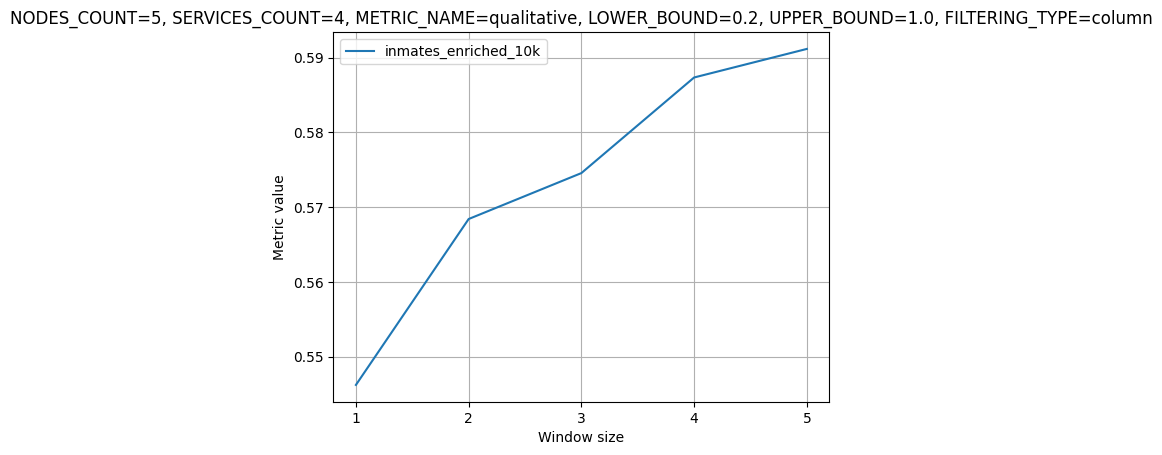

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.figure(figsize=(10, 6))

for dataset, dresults in agg_results_per_dataset.items():
    ax.plot(dresults.index, dresults['metric_value'], label=dataset)
    plt.xticks(dresults.index)

ax.set_title(f'NODES_COUNT={NODES_COUNT}, SERVICES_COUNT={SERVICES_COUNT}, METRIC_NAME={METRIC_NAME}, LOWER_BOUND={LOWER_BOUND}, UPPER_BOUND={UPPER_BOUND}, FILTERING_TYPE={FILTERING_TYPE}')
ax.set_xlabel('Window size')
ax.set_ylabel('Metric value')
ax.grid(True)
ax.legend()

plt.show()
    

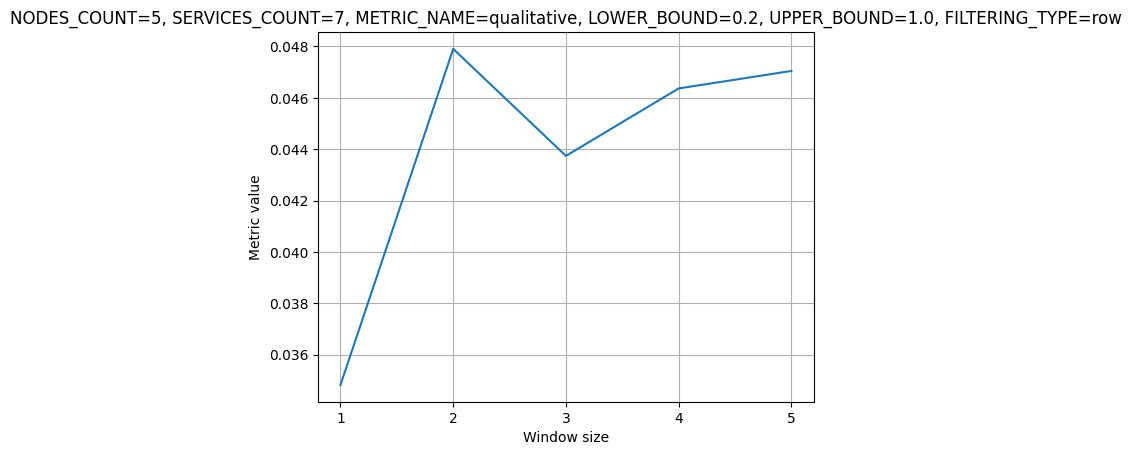

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.figure(figsize=(10, 6))

# x_series = agg_results_per_dataset['mixed'].index
# y_series = pd.Series([], dtype='Float64')
# for i in x_series:
#     y_series[i] = agg_results_per_dataset['mixed'].loc[i, 'metric_value'] - agg_results_per_dataset['row'].loc[i, 'metric_value']

# print(y_series)

ax.plot(agg_results_per_dataset['mixed'].index, agg_results_per_dataset['mixed'] - agg_results_per_dataset['row'])
plt.xticks(dresults.index)

ax.set_title(f'NODES_COUNT={NODES_COUNT}, SERVICES_COUNT={SERVICES_COUNT}, METRIC_NAME={METRIC_NAME}, LOWER_BOUND={LOWER_BOUND}, UPPER_BOUND={UPPER_BOUND}, FILTERING_TYPE={FILTERING_TYPE}')
ax.set_xlabel('Window size')
ax.set_ylabel('Metric value')
ax.grid(True)

plt.show()

## All experiments

Results for the same experiment id are not aggregated but have their own plot

In [15]:
results_per_dataset = {}
for dataset in tested_datasets:
    results_per_dataset[dataset] = {}
    dataset_results = apply_filters_to_dataset(results, results_filters + [lambda df: df['dataset'] == dataset])
    experiment_ids = dataset_results['experiment_id'].unique()
    for exp_id in experiment_ids:
        exp_id_results = dataset_results[dataset_results['experiment_id'] == exp_id][['window_size', 'metric_value']]
        results_per_dataset[dataset][exp_id] = exp_id_results

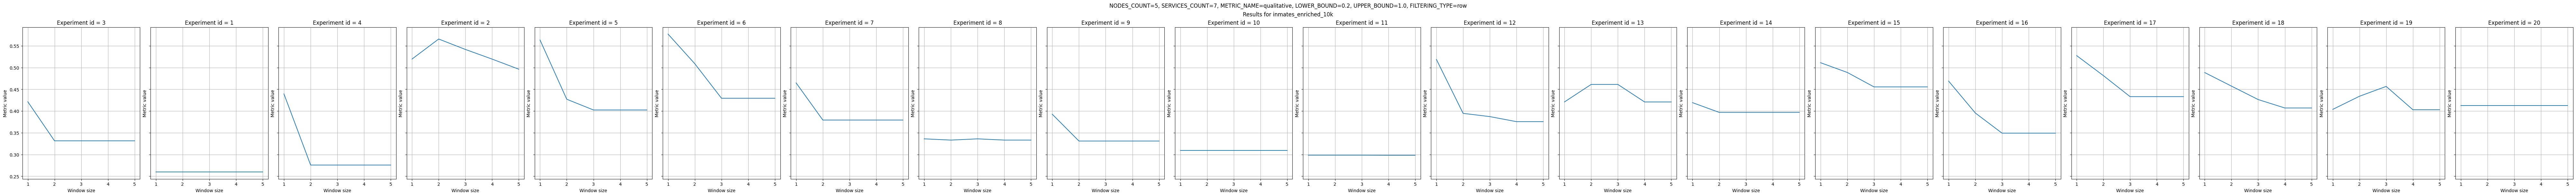

In [16]:
import matplotlib.pyplot as plt

fig_width = max(len(exp_res) for exp_res in results_per_dataset.values()) * 4

fig = plt.figure(figsize=(fig_width, 6), constrained_layout=True)
fig.suptitle(f'NODES_COUNT={NODES_COUNT}, SERVICES_COUNT={SERVICES_COUNT}, METRIC_NAME={METRIC_NAME}, LOWER_BOUND={LOWER_BOUND}, UPPER_BOUND={UPPER_BOUND}, FILTERING_TYPE={FILTERING_TYPE}')

dataset_res_count = len(results_per_dataset)
subfigs = fig.subfigures(nrows=dataset_res_count, ncols=1, squeeze=False)

for i, (dataset, dresults) in enumerate(results_per_dataset.items()):
    subfig = subfigs.item(i)
    subfig.suptitle(f'Results for {dataset}')

    axs = subfig.subplots(1, len(dresults), sharex=True, sharey=True, squeeze=False)
    # plt.figure(figsize=(10, 6))
    for exp_index, (exp_id, exp_id_results) in enumerate(dresults.items()):
        axs[i][exp_index].plot(exp_id_results['window_size'], exp_id_results['metric_value'])#, label=f'Experiment id = {exp_id}')
        axs[i][exp_index].set_xlabel('Window size')
        axs[i][exp_index].set_ylabel('Metric value')
        axs[i][exp_index].set_title(f'Experiment id = {exp_id}')
        axs[i][exp_index].grid(True)
        # axs[i][exp_id].legend()
        plt.xticks(exp_id_results['window_size'])

#fig.tight_layout()
plt.savefig('plot.png', bbox_inches='tight')
plt.show()

<style>
    .jp-RenderedHTMLCommon img {
        max-width: unset;
    }
</style>

<div style="max-width: unset;">
    <img src="plot.png" style="max-width: unset; max-height: unset"/>
</div>